In [19]:
import torch
from torchvision import transforms
import os

from utils.preprocess_image import preprocess_image
from utils.process_image import generate_latent_image, decompress_latent, generate_y_strings, get_no_strings_time, generate_compressed_image, save_ref_image
from utils.load_checkpoints import load_checkpoints
from utils.metric_calculation import calculate_psnr, calculate_lpips, calculate_bpp

from PIL import Image
from diffusers.models import AutoencoderKL
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics import PeakSignalNoiseRatio
from pillow_heif import register_heif_opener, register_avif_opener

#model setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
psnr_model = PeakSignalNoiseRatio().to(device)
lpips_model = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)

# Paths
images_path = '../kodak'
output_path = './outputs/sweep_all'
checkpoints_dir = '../checkpoints'

def create_latents(images_path, output_path, ae):
    ae_images = {}
    for image_name_bmp in os.listdir(images_path):
        
        image, image_name = preprocess_image(images_path, image_name_bmp, output_path)
        if image is None or image_name is None:
            continue 
        img_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
        with torch.no_grad():
            img_latent, encode_time = generate_latent_image(img_tensor, os.path.join(output_path, f'{image_name}_ae_latent.pt'), ae, save_encode_time=True)
            ae_decompressed_image, decode_time = decompress_latent(img_latent, os.path.join(output_path, f'{image_name}_ae_decomp.png'), ae, save_decode_time=True)

            ae_images[image_name] = {}
            ae_images[image_name]['encode_time'] = encode_time
            ae_images[image_name]['decode_time'] = decode_time
            ae_images[image_name]['image'] = image 
            ae_images[image_name]['image_size'] = image.size[0] * image.size[1]
            ae_images[image_name]['decomp_img'] = ae_decompressed_image
            ae_images[image_name]['latent'] = img_latent

    return ae_images


ae_images = create_latents(images_path, output_path, ae)

/home/ai1/ae-compress/venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/ai1/ae-compress/venv/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

Processing image: kodim09.png
Processing image: kodim15.png
Processing image: kodim23.png
Processing image: kodim19.png
Processing image: kodim12.png
Processing image: kodim01.png
Processing image: kodim17.png
Processing image: kodim22.png
Processing image: kodim05.png
Processing image: kodim08.png
Processing image: kodim03.png
Processing image: kodim02.png
Processing image: kodim13.png
Processing image: kodim06.png
Processing image: kodim07.png
Processing image: kodim16.png
Processing image: kodim21.png
Processing image: kodim10.png
Processing image: kodim11.png
Processing image: kodim14.png
Processing image: kodim24.png
Processing image: kodim04.png
Processing image: kodim18.png
Processing image: kodim20.png


In [20]:

import time

register_heif_opener()
register_avif_opener()

image_types = ['webp', 'jpeg', 'heif', 'avif'] 

image_quality = [10,20, 25,35,45,55,65,80,90]

#calculate metrics for reference image types and qualities
metrics = {}
for image_type in image_types:
    metrics[image_type] = {}
    for quality in image_quality:
        metrics[image_type][quality] = []
        for image_name, image_data in ae_images.items():
            #first does the compression and decompression from and to the latent, to measure the time
            start_time = time.time()
            save_ref_image(quality, f'qual_{quality}.{image_type}', image_data['decomp_img'], output_path, image_name)
            compression_time = time.time() - start_time

            start_time = time.time()
            decomp_img = Image.open(os.path.join(output_path, f'{image_name}_qual_{quality}.{image_type}'))
            decompression_time = time.time() - start_time
           
            metrics[image_type][quality].append({
                'image_name': image_name,
                'bpp': calculate_bpp(os.path.join(output_path, f'{image_name}_qual_{quality}.{image_type}'), ae_images[image_name]['image_size']),
                'psnr': calculate_psnr(ae_images[image_name]['decomp_img'], decomp_img),
                'lpips': calculate_lpips(ae_images[image_name]['decomp_img'], decomp_img),
                'compression_time': compression_time,
                'decompression_time': decompression_time
            })

In [21]:
lambda_vals = ["1e-3", "2e-3", "3e-3", "5e-4", "7e-4"]


import sys
sys.path.append('..')
from model import newModel

net = newModel(N=24, M=36).to(device)

#calculate metrics for our trained model
metrics['live'] = {}
for lambda_val in lambda_vals:
    metrics['live'][lambda_val] = []
    net = newModel(N=24,M=36).to(device)
    checkpoint = "checkpoint_"+lambda_val+"_best_loss.pth.tar"
    checkpoint_path = os.path.join(checkpoints_dir, checkpoint)
    print(checkpoint_path)
    
    load_checkpoints(checkpoint_path, net, device)
    net.update()
    
    with torch.no_grad():
        for image_name, image_data in ae_images.items():
            y_strings_path = os.path.join(output_path, f'{image_name}_y_strings.pt')
            y_strings, compressed_output, compression_time = generate_y_strings(image_data['latent'], y_strings_path, net, save_y_strings_time=True)
            no_strings_time = get_no_strings_time(image_data['latent'], net)
            compressed_image, decompression_time= generate_compressed_image(y_strings, compressed_output, os.path.join(output_path, f'{image_name}_{lambda_val}_compressed.png'), net, ae, save_decompress_time=True)
            item = {
                'image_name': image_name,
                'bpp': calculate_bpp(y_strings_path, image_data['image_size']),
                'psnr': calculate_psnr(image_data['decomp_img'], compressed_image),
                'lpips': calculate_lpips(image_data['decomp_img'], compressed_image),
                'compression_time': compression_time,
                'decompression_time': decompression_time,
                'no_strings_time': no_strings_time
            }
            metrics['live'][lambda_val].append(item)
        

../checkpoints/checkpoint_1e-3_best_loss.pth.tar


/home/ai1/ae-compress/testing/utils/load_checkpoints.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


../checkpoints/checkpoint_2e-3_best_loss.pth.tar
../checkpoints/checkpoint_3e-3_best_loss.pth.tar
../checkpoints/checkpoint_5e-4_best_loss.pth.tar
../checkpoints/checkpoint_7e-4_best_loss.pth.tar


In [22]:
#define utility functions to initialize and calculate average metrics
def calculate_average_ae_times(ae_images):
    """Calculate average encode and decode times for autoencoder images."""
    count = len(ae_images)
    if (not ae_images or count == 0):
        return 0, 0
        
    total_encode = sum(data['encode_time'] for data in ae_images.values())
    total_decode = sum(data['decode_time'] for data in ae_images.values())
    
    
    return total_encode / count, total_decode / count

def aggregate_metrics(count, metrics, metric_type):
    """Convert raw metric lists into averages."""
    return sum(item[metric_type] for item in metrics) / count if count > 0 else 0
    

def print_average_metric_result(averages, type, quality, metric):
    """Print formatted metrics summary."""
    print(f"Average {metric} for {type} with quality {quality}: {averages[metric][type][quality]}")

In [23]:
#Find the average bpp, psnr and lpips metric for each image and quality by image type
# Initialize dictionaries to store the average metrics (for everything except live)
average_metrics = {
    'bpp': {image_type: {quality: 0 for quality in image_quality} for image_type in image_types},
    'psnr': {image_type: {quality: 0 for quality in image_quality} for image_type in image_types},
    'lpips': {image_type: {quality: 0 for quality in image_quality} for image_type in image_types},
    'compression_time': {image_type: {quality: 0 for quality in image_quality} for image_type in image_types},
    'decompression_time': {image_type: {quality: 0 for quality in image_quality} for image_type in image_types}
}

#average encode and decode time for ae_images
average_encode_time, average_decode_time = calculate_average_ae_times(ae_images)

print(f"Average Encode Time: {average_encode_time}")
print(f"Average Decode Time: {average_decode_time}")

# Calculate the average bpp, psnr, lpips, compression time, and decompression time for each image type and quality
for image_type in image_types:
    for quality in image_quality:
        metrics_list = metrics[image_type][quality]
        count = len(metrics_list)
        average_metrics['bpp'][image_type][quality] = aggregate_metrics(count, metrics_list, 'bpp')
        average_metrics['psnr'][image_type][quality] = aggregate_metrics(count, metrics_list, 'psnr')
        average_metrics['lpips'][image_type][quality] = aggregate_metrics(count, metrics_list, 'lpips')
        average_metrics['compression_time'][image_type][quality] = aggregate_metrics(count, metrics_list, 'compression_time')
        average_metrics['decompression_time'][image_type][quality] = aggregate_metrics(count, metrics_list, 'decompression_time')
        

# Initialize dictionaries to store the average metrics for 'live'
average_metrics['no_strings_time'] = {}
average_metrics['bpp']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}
average_metrics['psnr']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}
average_metrics['lpips']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}
average_metrics['compression_time']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}
average_metrics['decompression_time']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}
average_metrics['no_strings_time']['live'] = {lambda_val: 0 for lambda_val in lambda_vals}

# Calculate the average metrics for 'live'
for lambda_val in lambda_vals:
    count = len(metrics['live'][lambda_val])
    metrics_list_live = metrics['live'][lambda_val]
    average_metrics['bpp']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'bpp')
    average_metrics['psnr']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'psnr')
    average_metrics['lpips']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'lpips')
    average_metrics['compression_time']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'compression_time')
    average_metrics['decompression_time']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'decompression_time')
    average_metrics['no_strings_time']['live'][lambda_val] = aggregate_metrics(count, metrics_list_live, 'no_strings_time')

# Print the average metrics (for everything except live)
for image_type in image_types:
    for quality in image_quality:
        for metric in ['bpp', 'psnr', 'lpips', 'compression_time', 'decompression_time']:
            print_average_metric_result(average_metrics, image_type, quality, metric)


# Print the average metrics summary for 'live'
print("Summary of average metrics for 'live':")
for lambda_val in lambda_vals:
    print(f"Lambda: {lambda_val}")
    print(f"  Average BPP: {average_metrics['bpp']['live'][lambda_val]}")
    print(f"  Average PSNR: {average_metrics['psnr']['live'][lambda_val]}")
    print(f"  Average LPIPS: {average_metrics['lpips']['live'][lambda_val]}")
    print(f"  Average Compression Time: {average_metrics['compression_time']['live'][lambda_val]}")
    print(f"  Average Decompression Time: {average_metrics['decompression_time']['live'][lambda_val]}")
    print(f"  Average No Strings Time: {average_metrics['no_strings_time']['live'][lambda_val]}")



Average Encode Time: 0.005372871955235799
Average Decode Time: 0.0061870912710825605
Average bpp for webp with quality 10: 0.2504035101996528
Average psnr for webp with quality 10: 29.646456638971966
Average lpips for webp with quality 10: 0.3255352048824231
Average compression_time for webp with quality 10: 0.026360829671223957
Average decompression_time for webp with quality 10: 0.0003455976645151774
Average bpp for webp with quality 20: 0.3431582980685764
Average psnr for webp with quality 20: 30.789591391881306
Average lpips for webp with quality 20: 0.2764896135777235
Average compression_time for webp with quality 20: 0.027879565954208374
Average decompression_time for webp with quality 20: 0.0003715356190999349
Average bpp for webp with quality 25: 0.3893449571397569
Average psnr for webp with quality 25: 31.26550777753194
Average lpips for webp with quality 25: 0.2565249986946583
Average compression_time for webp with quality 25: 0.028562992811203003
Average decompression_time f

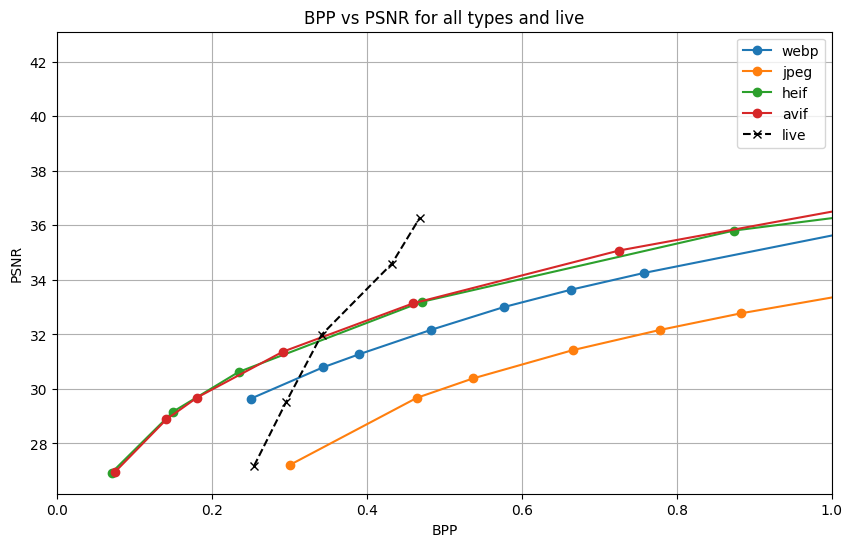

In [24]:
# Plot BPP vs PSNR for all types and 'live'
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for image_type in image_types:
    bpp_values = []
    psnr_values = []
    for quality in image_quality:
        bpp_values.append(average_metrics['bpp'][image_type][quality])
        psnr_values.append(average_metrics['psnr'][image_type][quality])
    
    plt.plot(bpp_values, psnr_values, marker='o', label=image_type)


# Add 'live' type to the plot
bpp_values_live = [average_metrics['bpp']['live'][lambda_val] for lambda_val in lambda_vals]
psnr_values_live = [average_metrics['psnr']['live'][lambda_val] for lambda_val in lambda_vals]

# Sort the live values by bpp
sorted_live_metrics = sorted(zip(bpp_values_live, psnr_values_live), key=lambda x: x[0])
bpp_values_live_sorted, psnr_values_live_sorted = zip(*sorted_live_metrics)

plt.plot(bpp_values_live_sorted, psnr_values_live_sorted, marker='x', linestyle='--', color='black', label='live')
plt.xlim(0, 1) 
plt.xlabel('BPP')
plt.ylabel('PSNR')
plt.title('BPP vs PSNR for all types and live')
plt.legend()
plt.grid(True)
plt.show()


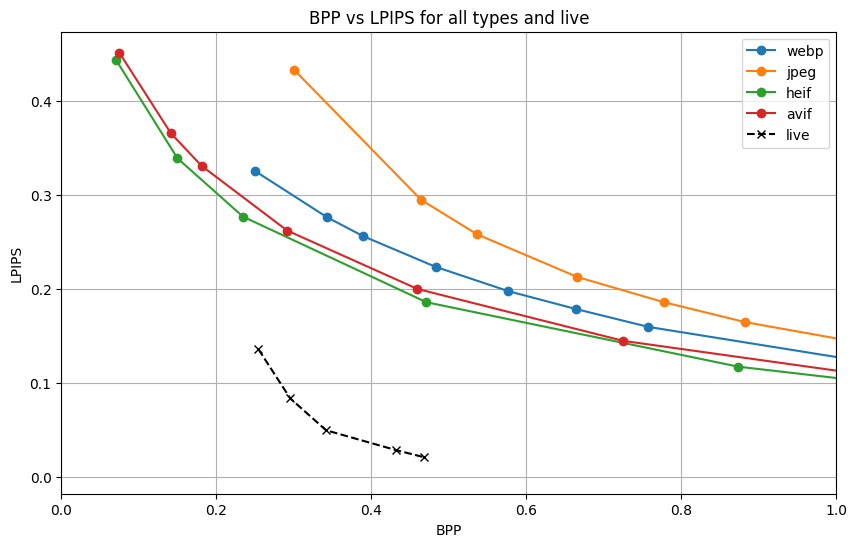

In [25]:
# Plot BPP vs LPIPS for all types and 'live'
plt.figure(figsize=(10, 6))

for image_type in image_types:
    bpp_values = []
    lpips_values = []
    for quality in image_quality:
        bpp_values.append(average_metrics['bpp'][image_type][quality])
        lpips_values.append(average_metrics['lpips'][image_type][quality])
    
    plt.plot(bpp_values, lpips_values, marker='o', label=image_type)

# Add 'live' type to the plot
bpp_values_live = [average_metrics['bpp']['live'][lambda_val] for lambda_val in lambda_vals]
lpips_values_live = [average_metrics['lpips']['live'][lambda_val] for lambda_val in lambda_vals]

# Sort the live values by bpp
sorted_live_metrics = sorted(zip(bpp_values_live, lpips_values_live), key=lambda x: x[0])
bpp_values_live_sorted, lpips_values_live_sorted = zip(*sorted_live_metrics)

plt.plot(bpp_values_live_sorted, lpips_values_live_sorted, marker='x', linestyle='--', color='black', label='live')
plt.xlim(0, 1) 
plt.xlabel('BPP')
plt.ylabel('LPIPS')
plt.title('BPP vs LPIPS for all types and live')
plt.legend()
plt.grid(True)
plt.show()


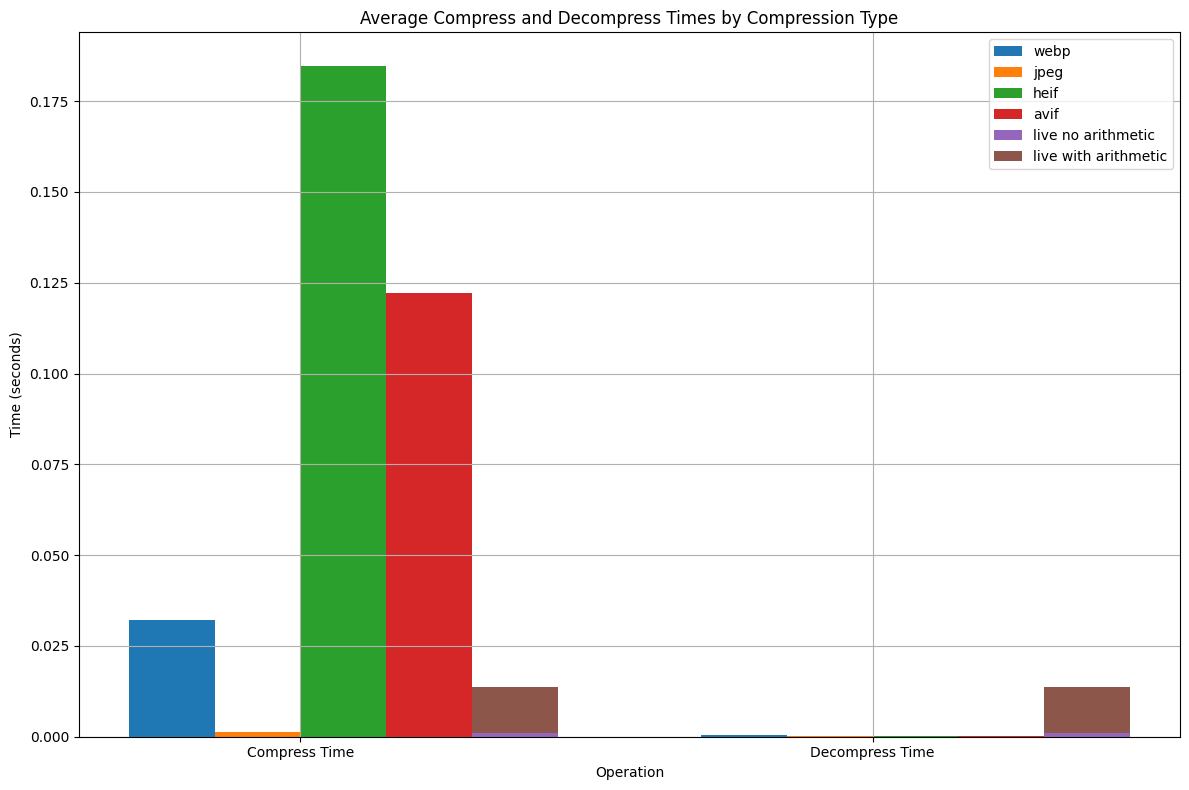

In [26]:
#Create a bar chart of compress and decompress time, also include encode and decode time of ae_images.  Remember to create averages first 
#Averages are over all bpp and quality settings and images
import numpy as np


# Stores compress and decompress times for each image type and quality
compress_times = {image_type: [] for image_type in image_types}
decompress_times = {image_type: [] for image_type in image_types}

for image_type in image_types:
    for quality in image_quality:
        compress_times[image_type].append(average_metrics['compression_time'][image_type][quality])
        decompress_times[image_type].append(average_metrics['decompression_time'][image_type][quality])

# Calculate average compress and decompress times for each image type (except live)
avg_compress_time = {image_type: np.mean(compress_times[image_type]) for image_type in image_types}
avg_decompress_time = {image_type: np.mean(decompress_times[image_type]) for image_type in image_types}

# Calculate average compress and decompress times for 'live' type
compress_times_live = [average_metrics['compression_time']['live'][lambda_val] for lambda_val in lambda_vals]
decompress_times_live = [average_metrics['decompression_time']['live'][lambda_val] for lambda_val in lambda_vals]
no_strings_times_live = [average_metrics['no_strings_time']['live'][lambda_val] for lambda_val in lambda_vals]

avg_no_strings_time = {}
avg_compress_time['live'] = np.mean(compress_times_live)
avg_decompress_time['live'] = np.mean(decompress_times_live)
avg_no_strings_time['live'] = np.mean(no_strings_times_live)

# Create a single bar chart with all image types
labels = ['Compress Time', 'Decompress Time']
x = np.arange(len(labels))  
width = 0.15  

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each image type
for i, image_type in enumerate(image_types):
    compress_time = avg_compress_time[image_type]
    decompress_time = avg_decompress_time[image_type]
    ax.bar(x + i * width, [compress_time, decompress_time], width, label=image_type)

# Add 'live' bar to the chart
compress_time_live = avg_compress_time['live']
decompress_time_live = avg_decompress_time['live']
ax.bar(x + len(image_types) * width, [avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], width, label='live no arithmetic')
ax.bar(x + len(image_types) * width, [compress_time_live, decompress_time_live], width,bottom=[avg_no_strings_time['live']/2, avg_no_strings_time['live']/2], label='live with arithmetic')




# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Compress and Decompress Times by Compression Type')
ax.set_xticks(x + width * (len(image_types) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()




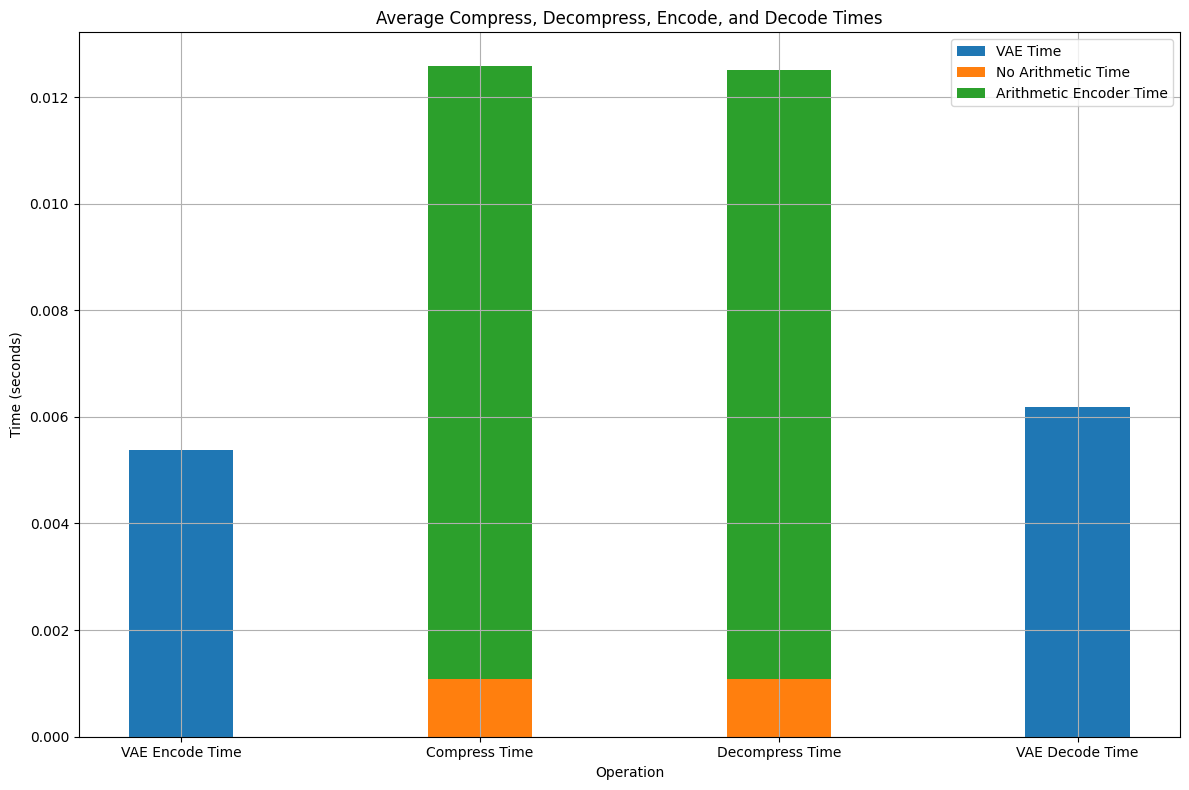

In [27]:
# Create a bar plot that has 'live' compress and decompress time as well as average encode and decode time
labels = ['VAE Encode Time', 'Compress Time', 'Decompress Time', 'VAE Decode Time',]
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for 'live' times
compress_time_live = avg_compress_time['live']
compress_strings_time = compress_time_live - avg_no_strings_time['live']/2
decompress_time_live = avg_decompress_time['live']
decompress_strings_time = decompress_time_live - avg_no_strings_time['live']/2
ax.bar(x, [average_encode_time, 0, 0, average_decode_time], width, align='center', label='VAE Time')
ax.bar(x, [0, avg_no_strings_time['live']/2, avg_no_strings_time['live']/2, 0], width, align='center', label='No Arithmetic Time')
ax.bar(x, [0, compress_strings_time, decompress_strings_time, 0  ], width, bottom=[0, avg_no_strings_time['live']/2, avg_no_strings_time['live']/2, 0], align='center', label='Arithmetic Encoder Time')

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Compress, Decompress, Encode, and Decode Times')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()